<a href="https://colab.research.google.com/github/pr401n/riverine-plastic-pollution/blob/main/riverine_random_forest_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🌍 River Plastic Pollution Contribution Classifier
============================================

This script implements a machine learning pipeline to classify rivers based on their
contribution to global plastic pollution. Using a Random Forest classifier with
robust feature engineering and evaluation metrics, it identifies high-risk rivers
for targeted intervention.

Key Features:
- Automated data cleaning and preprocessing
- Class imbalance handling
- Feature importance analysis
- Comprehensive model evaluation
- Production-ready code structure

In [103]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

In [104]:
# Constants
THRESHOLD = 6008  # Metric tons/year threshold for high pollution
RANDOM_STATE = 42  # For reproducibility
TEST_SIZE = 0.2    # Train-test split rati

In [105]:
#Load CSV from Google Drive

drive.mount('/content/drive')
csv_path = '/content/drive/MyDrive/data/global_riverine_plastic_emissions_into_ocean.csv'
df = pd.read_csv(csv_path)
#print(df.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [106]:
def clean_data_auto(df):
    """Automated column cleaning without manual naming."""

    # 1. Auto-detect numeric columns needing apostrophe removal
    num_pattern = r"\d+'\d+"
    str_num_cols = [col for col in df.columns
                   if df[col].astype(str).str.contains(num_pattern).any()]

    for col in str_num_cols:
        df[col] = df[col].astype(str).str.replace("'", "").astype(float)

    # 2. Auto-detect percentage columns
    pct_cols = [col for col in df.columns if '%' in col or '[%]' in col]
    for col in pct_cols:
        df[col] = df[col].astype(str).str.replace('%', '').astype(float) / 100

    # 3. Auto-select critical columns containing key terms
    critical_keywords = ['M[E]', 'Coast', 'Rainfall']
    critical_cols = [col for col in df.columns
                    if any(kwd in col for kwd in critical_keywords)]

    return df.dropna(subset=critical_cols)

data_clean = clean_data_auto(df)

In [107]:
# Remove columns where ALL values are NaN
data_clean = data_clean.dropna(axis=1, how='all')
print(data_clean.head())

  Country or Administrative area  Area [km2]  Coast length [km]  \
0                        Albania     28486.0              362.0   
1                        Algeria   2316559.0              998.0   
2                         Angola   1247357.0             1600.0   
3            Antigua and Barbuda       443.0              153.0   
4                      Argentina   2779705.0             4989.0   

   Rainfall [mm year -1]  Factor L/A [-]  Factor (L/A) *P [-]  P[E] [%]  \
0                 1117.0          0.0100                 14.0    0.0156   
1                   80.0          0.0004                  0.0    0.0009   
2                 1025.0          0.0010                  1.0    0.0009   
3                  996.0          0.3000                344.0    0.0308   
4                  567.0          0.0020                  1.0    0.0026   

   MPW (metric tons year -1)  M[E] (metric tons year -1) Ratio Me/MPW  
0                    69833.0                      1565.0        2.24%  
1 

In [108]:
# Create the new column using a conditional
data_clean['plastic_contribution'] = (data_clean['M[E] (metric tons year -1)'] <= THRESHOLD).astype(int)
print(data_clean.head())

  Country or Administrative area  Area [km2]  Coast length [km]  \
0                        Albania     28486.0              362.0   
1                        Algeria   2316559.0              998.0   
2                         Angola   1247357.0             1600.0   
3            Antigua and Barbuda       443.0              153.0   
4                      Argentina   2779705.0             4989.0   

   Rainfall [mm year -1]  Factor L/A [-]  Factor (L/A) *P [-]  P[E] [%]  \
0                 1117.0          0.0100                 14.0    0.0156   
1                   80.0          0.0004                  0.0    0.0009   
2                 1025.0          0.0010                  1.0    0.0009   
3                  996.0          0.3000                344.0    0.0308   
4                  567.0          0.0020                  1.0    0.0026   

   MPW (metric tons year -1)  M[E] (metric tons year -1) Ratio Me/MPW  \
0                    69833.0                      1565.0        2.24%   


In [109]:
# Base features
features = [
    'Area [km2]',
    'Coast length [km]',
    'Rainfall [mm year -1]',
    'MPW (metric tons year -1)',
    'P[E] [%]',
    'Factor (L/A) *P [-]'
]

In [110]:
# Add engineered features
data_clean['coast_to_area_ratio'] = data_clean['Coast length [km]'] / data_clean['Area [km2]'].replace(0, 1e-6)
data_clean['rainfall_per_km2'] = data_clean['Rainfall [mm year -1]'] / data_clean['Area [km2]'].replace(0, 1e-6)
features += ['coast_to_area_ratio', 'rainfall_per_km2']

X = data_clean[features]
y = data_clean['plastic_contribution']

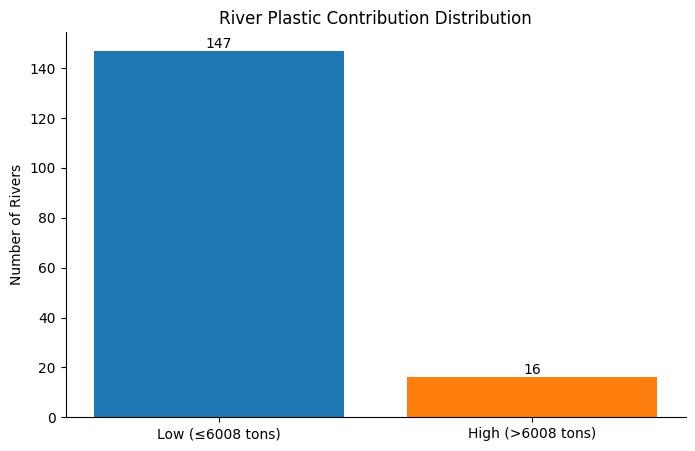

In [111]:
# Class distribution
plt.figure(figsize=(8,5))
counts = y.value_counts()
bars = plt.bar(['Low (≤6008 tons)', 'High (>6008 tons)'], counts, color=['#1f77b4','#ff7f0e'])
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height, f'{height:,}', ha='center', va='bottom')
plt.title('River Plastic Contribution Distribution')
plt.ylabel('Number of Rivers')
sns.despine()
plt.show()

In [112]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

In [113]:
# Feature scaling
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [114]:
# Model Training
model = RandomForestClassifier(
    n_estimators=500,
    max_depth=10,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
model.fit(X_train_scaled, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=5, n_estimators=500, n_jobs=-1,
                       random_state=42)

In [115]:
# [9] Evaluation
y_pred = model.predict(X_test_scaled)
print("=== Performance Metrics ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(f"Precision: {precision_score(y_test, y_pred):.2f}")
print(f"Recall: {recall_score(y_test, y_pred):.2f}\n")

print("=== Classification Report ===")
print(classification_report(y_test, y_pred))

=== Performance Metrics ===
Accuracy: 0.91
Precision: 0.91
Recall: 1.00

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.91      1.00      0.95        30

    accuracy                           0.91        33
   macro avg       0.45      0.50      0.48        33
weighted avg       0.83      0.91      0.87        33



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


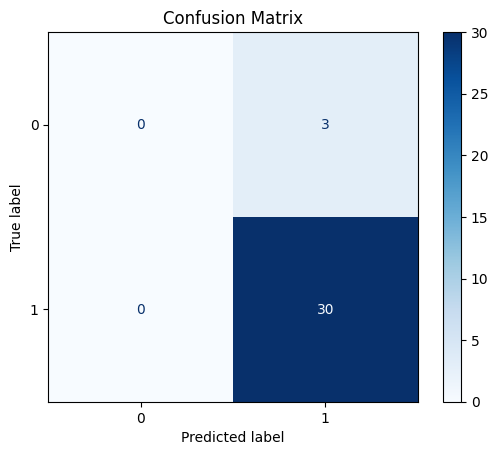

In [116]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

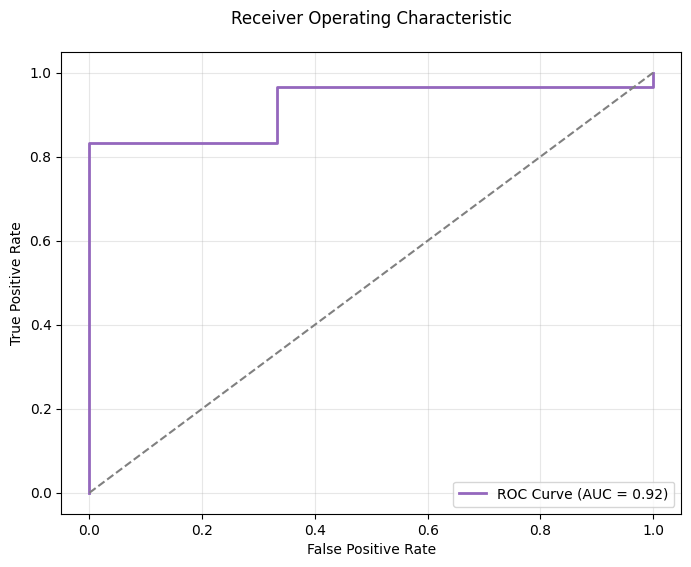

In [117]:
#ROC Curve Analysis
y_probs = model.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_probs)
auc_score = roc_auc_score(y_test, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='#9467bd', lw=2,
         label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic', pad=20)
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

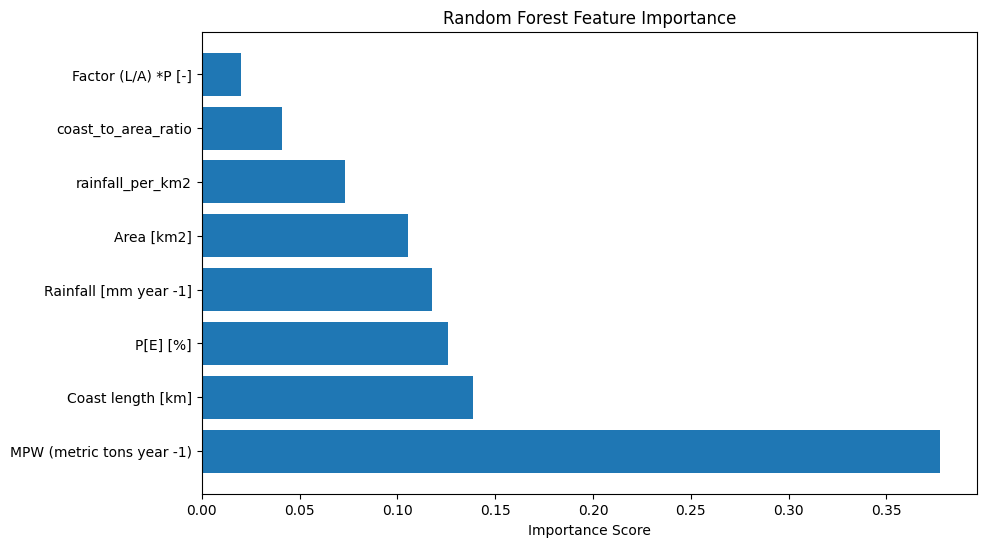

In [118]:
# Feature Importance
importances = model.feature_importances_
feature_imp = pd.DataFrame({'Feature': features, 'Importance': importances})\
               .sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_imp['Feature'], feature_imp['Importance'])
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance Score")
plt.show()

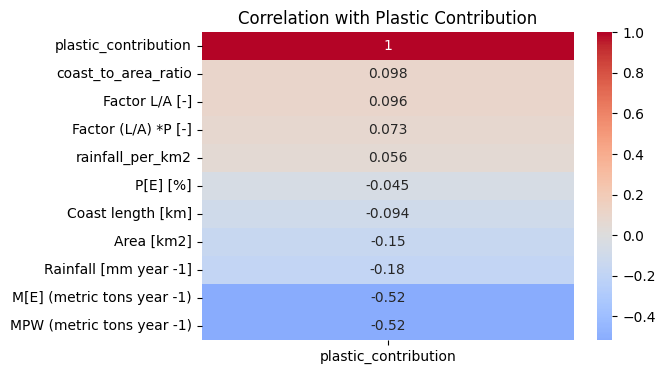

In [119]:
# Calculate correlations with target
correlations = data_clean.corr(numeric_only=True)[['plastic_contribution']]\
                 .sort_values('plastic_contribution', ascending=False)

# Visualize
plt.figure(figsize=(6, 4))
sns.heatmap(correlations, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation with Plastic Contribution")
plt.show()